In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.stats import sigma_clipped_stats, sigma_clip

import astropy.units as u
from astropy.io import ascii
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

%matplotlib inline

In [2]:
paths={'blue':'../ngc1087/hlsp_phangs-hst_hst_wfc3-uvis_ngc1087_f275w_v1_exp-drc-sci.fits','green':'../ngc1087/hlsp_phangs-hst_hst_wfc3-uvis_ngc1087_f438w_v1_exp-drc-sci.fits', 'red':'../ngc1087/hlsp_phangs-hst_hst_wfc3-uvis_ngc1087_f814w_v1_exp-drc-sci.fits'}

In [3]:
from astropy.visualization import simple_norm

def normalise_fits(fits_data, stretch='linear', percent=99.5):
    norm = simple_norm(fits_data, stretch=stretch ,percent=percent)
    normalized_data = norm(fits_data)
    
    return normalized_data

In [4]:
img={}
data, norm_data={}, {}
mean, median, std = {}, {}, {}

for key in paths:
    img[key]=fits.open(paths[key])
   
    data[key]=ma.masked_equal(img[key][0].data, 0)
    
    norm_data[key]=normalise_fits(data[key])
    mean[key], median[key], std[key] = sigma_clipped_stats(norm_data[key])
    
    img[key].close()

In [5]:
rgb_image = np.zeros((norm_data['blue'].shape[0], norm_data['blue'].shape[1], 3))
rgb_image[..., 0] = norm_data['red']  # Red channel
rgb_image[..., 1] = norm_data['green']  # Green channel
rgb_image[..., 2] = norm_data['blue']  # Blue channel

In [6]:
img=fits.open(paths['green'])
img_details= img[0].header

ra_img_centre, dec_img_centre = img_details['CRVAL1'], img_details['CRVAL2']
pixel_centre=(img_details['CRPIX1'], img_details['CRPIX2'])

from astropy.wcs import WCS

# conversion from ra-decluster_pixels[0], cluster_pixels[1]c to pixel
def radec_to_pixel(equi, img_details=img_details):
    w = WCS(img_details)
    # ra, dec = equi
    x, y = w.all_world2pix([equi], 1)[0]  # Using origin=1 for FITS standard
    return [x, y]

In [7]:
catalog_img=fits.open('../ngc1087/catalogs/hlsp_phangs-cat_hst_uvis_ngc1087_multi_v1_obs-human-cluster-class12.fits')
catalog_data=catalog_img[1].data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


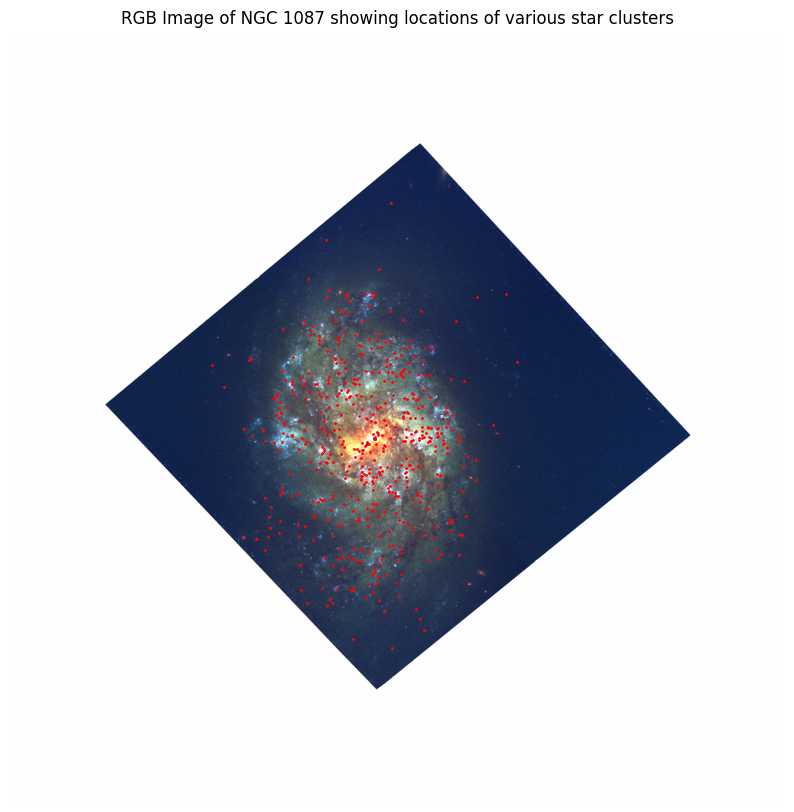

In [8]:
cluster_equi_coord = np.array([catalog_data['PHANGS_RA'], catalog_data['PHANGS_DEC']]).T
cluster_pixels = [radec_to_pixel(equi_coord) for equi_coord in cluster_equi_coord]

plt.figure(figsize=(10, 10))
plt.imshow(rgb_image, origin='lower')
plt.title('RGB Image of NGC 1087 showing locations of various star clusters')
plt.axis('equal')
plt.axis('off')
plt.plot(*np.array(cluster_pixels).T, 'ro', markersize=1)
# plt.savefig('ngc1087_rgb_with_clusters.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()